<a href="https://www.kaggle.com/code/engdhay/eeg-part-four?scriptVersionId=282138448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# ΔΦ Operator Implementation – FBD Lab Theory  
* Practical Application

* This code implements the ΔΦ operator following the formal specification 
* defined by the FBD (Functional Brain Dynamics) laboratory framework.
*
* **Purpose:**
* The ΔΦ operator quantifies deviations of brain states from baseline 
* along three functional axes: S (Structural), I (Informational), and 
* C (Coherence). It is applied to EEG-derived features to detect dynamic 
* regimes including Isostasis, Allostasis, High-Allostasis, and Collapse.
*
* **Authors of the ΔΦ Theory:**
* - Pasquale Kaboth
* - Marcel Theodor Wende
* - Marcel Krüger
*
* This implementation adapts the original equations into Python, 
* applies baseline normalization, computes ΔS, ΔI, ΔC, and calculates 
* the global ΔΦ per window.
*
* **Core Equations:**
* ΔS(x) = S(x) − S_baseline  
* ΔI(x) = I(x) − I_baseline  
* ΔC(x) = C(x) − C_baseline  
* ΔΦ(x) = 0.40 * |ΔS(x)| + 0.35 * |ΔI(x)| + 0.25 * |ΔC(x)|
*
* **Regime Thresholds:**
* - Isostasis: ΔΦ < 0.15  
* - Allostasis: 0.15 ≤ ΔΦ < 0.35  
* - High-Allostasis: 0.35 ≤ ΔΦ < 0.40  
* - Collapse: ΔΦ ≥ 0.40
*
* **DLHR Axes Mapping to Features:**
* - S: Ricci curvature, curvature variance (structural order)  
* - I: Permutation entropy (informational differentiation)  
* - C: Correlation structure, H1 persistence (coherence)
*
* **Implementation and Code Author:**
* - Dhay Amer Kadhim
* **Methodology and concept:**
* - Arturo Salazar Chon
*
* **Note:**
* All parameters (α, β, γ, thresholds, baseline mode) are fixed 
* to ensure reproducibility and alignment with the FBD laboratory directive.



# There are two ways to write this code for patients.
# The first method.
* The first method is not used solely for informational purposes.

In [1]:
'''
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "/kaggle/input/ica-egg"  #fif
output_csv = "ica_features.csv"

all_rows = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".fif"):
        continue
    filepath = os.path.join(data_dir, fname)
    
    print(f"[INFO] Loading {fname} ...")
    raw = mne.io.read_raw_fif(filepath, preload=True, verbose=False)
    
    patient = fname.split("_")[0]
    if "before" in fname.lower():
        phase = "Before"
    elif "after" in fname.lower():
        phase = "After"
    else:
        phase = "During"
    
    win_len_s = 10
    sfreq = raw.info['sfreq']
    n_samples_per_win = int(win_len_s * sfreq)
    n_windows = raw.n_times // n_samples_per_win
    
    for i in range(n_windows):
        start = i * n_samples_per_win
        end = start + n_samples_per_win
        if end > raw.n_times:
            end = raw.n_times
        
        window_data = raw.get_data(start=start, stop=end)
        
        # Structural metrics (S)
        mean_ricci = np.mean(window_data)
        var_ricci = np.var(window_data)
        pers_H1 = np.max(window_data) - np.min(window_data)
        mean_H1 = np.mean(np.abs(window_data))
        
        # Informational metrics (I)
        HPE_mean = np.mean(np.log1p(np.abs(window_data)))
        
        # Coherence metrics (C)
        VarCorr = np.var(np.corrcoef(window_data))
        BlockAlign = np.mean(window_data)
        
        all_rows.append({
            "Patient": patient,
            "Phase": phase,
            "win_start_s": start / sfreq,
            "win_end_s": end / sfreq,
            "MeanRicci": mean_ricci,
            "VarRicci": var_ricci,
            "Pers_H1": pers_H1,
            "MeanH1": mean_H1,
            "HPE_mean": HPE_mean,
            "VarCorr": VarCorr,
            "BlockAlign": BlockAlign,
        })

df_features = pd.DataFrame(all_rows)
df_features.to_csv(output_csv, index=False)
print(f"[INFO] CSV saved to {output_csv} ({len(df_features)} windows)")
'''

'\nimport os\nimport mne\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\ndata_dir = "/kaggle/input/ica-egg"  #fif\noutput_csv = "ica_features.csv"\n\nall_rows = []\n\nfor fname in os.listdir(data_dir):\n    if not fname.endswith(".fif"):\n        continue\n    filepath = os.path.join(data_dir, fname)\n    \n    print(f"[INFO] Loading {fname} ...")\n    raw = mne.io.read_raw_fif(filepath, preload=True, verbose=False)\n    \n    patient = fname.split("_")[0]\n    if "before" in fname.lower():\n        phase = "Before"\n    elif "after" in fname.lower():\n        phase = "After"\n    else:\n        phase = "During"\n    \n    win_len_s = 10\n    sfreq = raw.info[\'sfreq\']\n    n_samples_per_win = int(win_len_s * sfreq)\n    n_windows = raw.n_times // n_samples_per_win\n    \n    for i in range(n_windows):\n        start = i * n_samples_per_win\n        end = start + n_samples_per_win\n        if end > raw.n_times:\n            end = raw

In [2]:


'''
# ==========================
# Constants / Theory Parameters
# ==========================
ALPHA  = 0.40          # weight for Structural component (S)
BETA   = 0.35          # weight for Informational component (I)
GAMMA  = 0.25          # weight for Coherence component (C)

TH_ISOSTASIS   = 0.15  # ΔΦ < 0.15 -> Isostasis (stable)
TH_ALLOSTASIS  = 0.35  # ΔΦ < 0.35 -> Allostasis (adaptive)
TH_HIGH_ALLO   = 0.40  # ΔΦ < 0.40 -> High Allostasis
TH_COLLAPSE    = 0.40  # ΔΦ >= 0.40 -> Collapse (system failure)

MIN_COLLAPSE_WINDOWS = 2
NORMALIZATION_METHOD = "minmax"
BASELINE_MODE        = "global"  # options: global, patient, after

WINDOW_LEN_S = 10     
'''

'''
# ==========================
#  ΔΦ Analysis + Regimes + Collapse
# ==========================

from dataclasses import dataclass
from typing import List, Optional, Union, Literal
# --------------------------
# Configuration dataclasses
# --------------------------
@dataclass
class MetricMapping:
    structural_metrics: List[str]
    informational_metrics: List[str]
    coherence_metrics: List[str]

@dataclass
class DeltaPhiConfig:
    metric_mapping: MetricMapping
    alpha: float = 0.4
    beta: float = 0.35
    gamma: float = 0.25
    allostasis_lower: float = 0.15
    allostasis_upper: float = 0.35
    collapse_threshold: float = 0.4
    min_collapse_windows: int = 2
    normalization: Literal["minmax","zscore"] = "minmax"
    baseline_label_column: Optional[str] = None
    baseline_label_values: Optional[List[Union[str,int,float]]] = None

# --------------------------
# Normalization helpers
# --------------------------
def _minmax_normalize(series):
    s = series.astype(float)
    lo, hi = np.nanmin(s), np.nanmax(s)
    if np.isclose(lo,hi):
        return pd.Series(0.5, index=s.index)
    return (s-lo)/(hi-lo)

def _zscore_normalize(series):
    s = series.astype(float)
    mu, sd = np.nanmean(s), np.nanstd(s)
    if sd==0: return pd.Series(0, index=s.index)
    return (s-mu)/sd

def _normalize_column(df, col, method):
    if method=="minmax":
        return _minmax_normalize(df[col])
    elif method=="zscore":
        return _zscore_normalize(df[col])
    else:
        raise ValueError(f"Unknown normalization: {method}")
'''
#=====================
'''
# other way to normalize 
feature_cols = ["MeanRicci","VarRicci","Pers_H1","MeanH1","HPE_mean","VarCorr","BlockAlign"]
df_norm = df.copy()
for col in feature_cols:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min() + 1e-9)
'''
#=================================
'''
# --------------------------
# Compute S, I, C
# --------------------------
def compute_SIC(df, config):
    mm = config.metric_mapping
    df_out = df.copy()
    norm_struct = {c: _normalize_column(df_out,c,config.normalization) for c in mm.structural_metrics}
    norm_info = {c: _normalize_column(df_out,c,config.normalization) for c in mm.informational_metrics}
    norm_coh = {c: _normalize_column(df_out,c,config.normalization) for c in mm.coherence_metrics}

    df_out["S"] = pd.DataFrame(norm_struct).mean(axis=1) if norm_struct else np.nan
    df_out["I"] = pd.DataFrame(norm_info).mean(axis=1) if norm_info else np.nan
    df_out["C"] = pd.DataFrame(norm_coh).mean(axis=1) if norm_coh else np.nan
    return df_out


'''
#======================
'''
# other way S / I / C
df_norm["S"] = df_norm[["MeanRicci","VarRicci","Pers_H1","MeanH1"]].mean(axis=1)
df_norm["I"] = df_norm[["HPE_mean"]].mean(axis=1)
df_norm["C"] = df_norm[["VarCorr","BlockAlign"]].mean(axis=1)

'''
#===========================
'''
# --------------------------
# ΔΦ computation
# --------------------------
def _compute_baseline_generic(df_sic, baseline_mask):
    base = df_sic[baseline_mask] if baseline_mask.any() else df_sic
    return {"S": float(base["S"].median()),
            "I": float(base["I"].median()),
         "C": float(base["C"].median())}

# Δ relative to baseline (global)
baseline_S = df_norm["S"].mean()
baseline_I = df_norm["I"].mean()
baseline_C = df_norm["C"].mean()

df_norm["ΔS"] = df_norm["S"] - baseline_S
df_norm["ΔI"] = df_norm["I"] - baseline_I
df_norm["ΔC"] = df_norm["C"] - baseline_C



def compute_delta_phi_with_mask(df, config, baseline_mask, suffix):
    df_sic = compute_SIC(df, config) if not {"S","I","C"}.issubset(df.columns) else df.copy()
    baseline = _compute_baseline_generic(df_sic, baseline_mask)
    out = df_sic.copy()
    out[f"dS{suffix}"] = out["S"] - baseline["S"]
    out[f"dI{suffix}"] = baseline["I"] - out["I"]
    out[f"dC{suffix}"] = out["C"] - baseline["C"]
    out[f"DeltaPhi{suffix}"] = config.alpha*out[f"dS{suffix}"] + config.beta*out[f"dI{suffix}"] + config.gamma*out[f"dC{suffix}"]
    return out

def compute_all_delta_phi_variants(df, config):
    df_sic = compute_SIC(df, config) if not {"S","I","C"}.issubset(df.columns) else df.copy()
    
    # 1. Global baseline
    mask_global = df_sic["Phase"].isin(["Before","After"]) if "Phase" in df_sic.columns else pd.Series(True,index=df_sic.index)
    out = compute_delta_phi_with_mask(df_sic, config, mask_global, "_global")
    
    # 2. Use _global as main DeltaPhi column
    out["DeltaPhi"] = out["DeltaPhi_global"]
    
    # 3. Per-patient baseline
    out["DeltaPhi_patient"]=np.nan; out["dS_patient"]=np.nan; out["dI_patient"]=np.nan; out["dC_patient"]=np.nan
    if "Patient" in out.columns and "Phase" in out.columns:
        for pid, sub in out.groupby("Patient"):
            mask_pa = sub["Phase"].isin(["Before","After"])
            sub_with_delta = compute_delta_phi_with_mask(sub, config, mask_pa, "_p")
            out.loc[sub.index,"DeltaPhi_patient"]=sub_with_delta["DeltaPhi_p"]
            out.loc[sub.index,"dS_patient"]=sub_with_delta["dS_p"]
            out.loc[sub.index,"dI_patient"]=sub_with_delta["dI_p"]
            out.loc[sub.index,"dC_patient"]=sub_with_delta["dC_p"]
    
    # 4. After-only baseline
    mask_after = out["Phase"].eq("After") if "Phase" in out.columns else pd.Series(True,index=out.index)
    out_after = compute_delta_phi_with_mask(out, config, mask_after, "_after")
    out["DeltaPhi_after"]=out_after["DeltaPhi_after"]
    out["dS_after"]=out_after["dS_after"]
    out["dI_after"]=out_after["dI_after"]
    out["dC_after"]=out_after["dC_after"]
    
    return out



#  ΔΦ
df_norm["DeltaPhi_global"] = ( ALPHA * np.abs(df_norm["ΔS"]) +BETA  * np.abs(df_norm["ΔI"]) +
    GAMMA * np.abs(df_norm["ΔC"]))

# --------------------------
# Regime classification
# --------------------------
def classify_regime(df, config, col="DeltaPhi"):
    out = df.copy()
    def _classify(x):
        if np.isnan(x): return "Unknown"
        if x>=config.collapse_threshold: return "Collapse"
        if x<config.allostasis_lower: return "Isostasis"
        if x<config.allostasis_upper: return "Allostasis"
        return "High-Allostasis"
    out["Regime"] = out[col].apply(_classify)
    return out

# --------------------------
# Collapse segments
# --------------------------
def mark_collapse_segments(df, config, col="DeltaPhi", group_column="Patient"):
    out = df.copy()
    out["CollapseSegmentID"]=-1
    groups = out.groupby(group_column) if group_column in out.columns else [(None,out)]
    seg_id=0
    for _,sub in groups:
        idxs=list(sub.index)
        flags=(sub[col]>=config.collapse_threshold).tolist()
        run_start=None
        for i,flag in enumerate(flags):
            if flag and run_start is None:
                run_start=i
            elif not flag and run_start is not None:
                if i-run_start>=config.min_collapse_windows:
                    seg_id+=1
                    out.loc[idxs[run_start:i],"CollapseSegmentID"]=seg_id
                run_start=None
        if run_start is not None and len(flags)-run_start>=config.min_collapse_windows:
            seg_id+=1
            out.loc[idxs[run_start:len(flags)],"CollapseSegmentID"]=seg_id
    return out

# --------------------------
# Example FBD config
# --------------------------
def example_fbd_config():
    metric_mapping = MetricMapping(
        structural_metrics=["MeanRicci","VarRicci","Pers_H1","MeanH1"],
        informational_metrics=["HPE_mean"],
        coherence_metrics=["VarCorr","BlockAlign"]
    )
    return DeltaPhiConfig(
        metric_mapping=metric_mapping,
        baseline_label_column="Phase",
        baseline_label_values=["Before","After","Healthy"]
    )
'''

'\n# --------------------------\n# ΔΦ computation\n# --------------------------\ndef _compute_baseline_generic(df_sic, baseline_mask):\n    base = df_sic[baseline_mask] if baseline_mask.any() else df_sic\n    return {"S": float(base["S"].median()),\n            "I": float(base["I"].median()),\n         "C": float(base["C"].median())}\n\n# Δ relative to baseline (global)\nbaseline_S = df_norm["S"].mean()\nbaseline_I = df_norm["I"].mean()\nbaseline_C = df_norm["C"].mean()\n\ndf_norm["ΔS"] = df_norm["S"] - baseline_S\ndf_norm["ΔI"] = df_norm["I"] - baseline_I\ndf_norm["ΔC"] = df_norm["C"] - baseline_C\n\n\n\ndef compute_delta_phi_with_mask(df, config, baseline_mask, suffix):\n    df_sic = compute_SIC(df, config) if not {"S","I","C"}.issubset(df.columns) else df.copy()\n    baseline = _compute_baseline_generic(df_sic, baseline_mask)\n    out = df_sic.copy()\n    out[f"dS{suffix}"] = out["S"] - baseline["S"]\n    out[f"dI{suffix}"] = baseline["I"] - out["I"]\n    out[f"dC{suffix}"] = out["C

In [3]:
'''
#  Run full pipeline & generate images
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("/kaggle/working/ica_features.csv")

# config
config = example_fbd_config()

# --------------------------
#  DeltaPhi
# --------------------------
df_phi = compute_all_delta_phi_variants(df, config)

# --------------------------
# DeltaPhi 
# --------------------------
df_phi = classify_regime(df_phi, config, col="DeltaPhi")

# --------------------------
# (Collapse segments)
# --------------------------
df_phi = mark_collapse_segments(df_phi, config, col="DeltaPhi", group_column="Patient")

# --------------------------
# save
# --------------------------
df_phi.to_csv("ica_features_with_delta_phi.csv", index=False)
print("[INFO] Augmented CSV saved: ica_features_with_delta_phi.csv")

# --------------------------
# figs
# --------------------------
plt.figure(figsize=(8,6))
sns.histplot(df_phi["DeltaPhi"], kde=True, bins=30)
plt.title("DeltaPhi Distribution")
plt.xlabel("DeltaPhi")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("DeltaPhi_distribution.png", dpi=150)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x="Phase", y="DeltaPhi", data=df_phi)
plt.title("DeltaPhi per Phase")
plt.xlabel("Phase")
plt.ylabel("DeltaPhi")
plt.tight_layout()
plt.savefig("DeltaPhi_per_phase.png", dpi=150)
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(x="win_start_s", y="DeltaPhi", hue="Patient", data=df_phi, marker="o")
plt.title("DeltaPhi over Time per Patient")
plt.xlabel("Time (s)")
plt.ylabel("DeltaPhi")
plt.legend(title="Patient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("DeltaPhi_over_time.png", dpi=150)
plt.show()

print("[INFO] Images saved: DeltaPhi_distribution.png, DeltaPhi_per_phase.png, DeltaPhi_over_time.png")
'''

'\n#  Run full pipeline & generate images\nimport warnings\nwarnings.filterwarnings("ignore", category=RuntimeWarning)\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\ndf = pd.read_csv("/kaggle/working/ica_features.csv")\n\n# config\nconfig = example_fbd_config()\n\n# --------------------------\n#  DeltaPhi\n# --------------------------\ndf_phi = compute_all_delta_phi_variants(df, config)\n\n# --------------------------\n# DeltaPhi \n# --------------------------\ndf_phi = classify_regime(df_phi, config, col="DeltaPhi")\n\n# --------------------------\n# (Collapse segments)\n# --------------------------\ndf_phi = mark_collapse_segments(df_phi, config, col="DeltaPhi", group_column="Patient")\n\n# --------------------------\n# save\n# --------------------------\ndf_phi.to_csv("ica_features_with_delta_phi.csv", index=False)\nprint("[INFO] Augmented CSV saved: ica_features_with_delta_phi.csv")\n\n# --------------------------\n# figs\n# ------------------------

In [4]:
'''
regime_colors = {
    "Isostasis":"green",
    "Allostasis":"orange",
    "High-Allostasis":"purple",
    "Collapse":"red",
    "Unknown":"gray"
}

for pid in df_phi["Patient"].unique():
    sub = df_phi[df_phi["Patient"]==pid].reset_index()
    plt.figure(figsize=(12,3))
    colors = sub["Regime"].map(regime_colors)
    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', linewidth=1)
    plt.title(f"Patient {pid}: ΔΦ and Regimes")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ")
    plt.show()
    '''

'\nregime_colors = {\n    "Isostasis":"green",\n    "Allostasis":"orange",\n    "High-Allostasis":"purple",\n    "Collapse":"red",\n    "Unknown":"gray"\n}\n\nfor pid in df_phi["Patient"].unique():\n    sub = df_phi[df_phi["Patient"]==pid].reset_index()\n    plt.figure(figsize=(12,3))\n    colors = sub["Regime"].map(regime_colors)\n    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)\n    plt.plot(sub.index, sub["DeltaPhi_global"], color=\'black\', linewidth=1)\n    plt.title(f"Patient {pid}: ΔΦ and Regimes")\n    plt.xlabel("Window index")\n    plt.ylabel("ΔΦ")\n    plt.show()\n    '

In [5]:
'''
for pid in df_phi["Patient"].unique():
    sub = df_phi[df_phi["Patient"]==pid].reset_index()
    plt.figure(figsize=(12,4))
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', label='ΔΦ_global', linewidth=2)
    collapse_idx = sub.index[sub["DeltaPhi_global"] >= config.collapse_threshold]
    plt.scatter(collapse_idx, sub.loc[collapse_idx,"DeltaPhi_global"], color='red', label="Collapse windows")
    plt.title(f"Patient {pid}: Collapse & High-ΔΦ windows")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ")
    plt.legend()
    plt.show()'''

'\nfor pid in df_phi["Patient"].unique():\n    sub = df_phi[df_phi["Patient"]==pid].reset_index()\n    plt.figure(figsize=(12,4))\n    plt.plot(sub.index, sub["DeltaPhi_global"], color=\'black\', label=\'ΔΦ_global\', linewidth=2)\n    collapse_idx = sub.index[sub["DeltaPhi_global"] >= config.collapse_threshold]\n    plt.scatter(collapse_idx, sub.loc[collapse_idx,"DeltaPhi_global"], color=\'red\', label="Collapse windows")\n    plt.title(f"Patient {pid}: Collapse & High-ΔΦ windows")\n    plt.xlabel("Window index")\n    plt.ylabel("ΔΦ")\n    plt.legend()\n    plt.show()'

In [6]:
'''
for pid in patients:
    df = pd.read_csv("ica_features_with_delta_phi.csv")
    sub = df[df["Patient"]==pid].reset_index()
    plt.figure(figsize=(12,3))
    colors = sub["CollapseSegmentID"].apply(lambda x: 'red' if x!=-1 else 'gray')
    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', linewidth=1)
    plt.title(f"Patient {pid}: Collapse segments (red)")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ_global")
    plt.show()
    '''


'\nfor pid in patients:\n    df = pd.read_csv("ica_features_with_delta_phi.csv")\n    sub = df[df["Patient"]==pid].reset_index()\n    plt.figure(figsize=(12,3))\n    colors = sub["CollapseSegmentID"].apply(lambda x: \'red\' if x!=-1 else \'gray\')\n    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)\n    plt.plot(sub.index, sub["DeltaPhi_global"], color=\'black\', linewidth=1)\n    plt.title(f"Patient {pid}: Collapse segments (red)")\n    plt.xlabel("Window index")\n    plt.ylabel("ΔΦ_global")\n    plt.show()\n    '

In [7]:
'''
for pid in patients:
    df = pd.read_csv("ica_features_with_delta_phi.csv")
    sub = df[df["Patient"]==pid].reset_index()
    plt.figure(figsize=(12,5))
    plt.plot(sub.index, sub["S"], label="S", marker='o')
    plt.plot(sub.index, sub["I"], label="I", marker='s')
    plt.plot(sub.index, sub["C"], label="C", marker='^')
    plt.plot(sub.index, sub["DeltaPhi_global"], label="ΔΦ_global", color='black', linewidth=2)
    plt.title(f"Patient {pid}: S, I, C and ΔΦ over windows")
    plt.xlabel("Window index")
    plt.ylabel("Normalized value")
    plt.legend()
    plt.tight_layout()
    plt.show()
    '''


'\nfor pid in patients:\n    df = pd.read_csv("ica_features_with_delta_phi.csv")\n    sub = df[df["Patient"]==pid].reset_index()\n    plt.figure(figsize=(12,5))\n    plt.plot(sub.index, sub["S"], label="S", marker=\'o\')\n    plt.plot(sub.index, sub["I"], label="I", marker=\'s\')\n    plt.plot(sub.index, sub["C"], label="C", marker=\'^\')\n    plt.plot(sub.index, sub["DeltaPhi_global"], label="ΔΦ_global", color=\'black\', linewidth=2)\n    plt.title(f"Patient {pid}: S, I, C and ΔΦ over windows")\n    plt.xlabel("Window index")\n    plt.ylabel("Normalized value")\n    plt.legend()\n    plt.tight_layout()\n    plt.show()\n    '

In [8]:
'''
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import roc_curve, auc
import numpy as np

phase_of_interest = "During"
df = pd.read_csv("ica_features_with_delta_phi.csv")
df["Label"] = (df["Phase"]==phase_of_interest).astype(int)

fpr, tpr, _ = roc_curve(df["Label"], df["DeltaPhi_global"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve: ΔΦ_global vs Phase=='{phase_of_interest}'")
plt.legend(loc="lower right")
plt.show()
'''


'\nimport warnings\nwarnings.filterwarnings("ignore", category=RuntimeWarning)\nfrom sklearn.metrics import roc_curve, auc\nimport numpy as np\n\nphase_of_interest = "During"\ndf = pd.read_csv("ica_features_with_delta_phi.csv")\ndf["Label"] = (df["Phase"]==phase_of_interest).astype(int)\n\nfpr, tpr, _ = roc_curve(df["Label"], df["DeltaPhi_global"])\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(6,6))\nplt.plot(fpr, tpr, color=\'blue\', lw=2, label=f\'AUC = {roc_auc:.2f}\')\nplt.plot([0,1],[0,1], color=\'gray\', linestyle=\'--\')\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.title(f"ROC Curve: ΔΦ_global vs Phase==\'{phase_of_interest}\'")\nplt.legend(loc="lower right")\nplt.show()\n'

# -------------------------------------------------------------------

#  The second method
* which we will work on.

In [9]:
import os
import mne
import pandas as pd
import numpy as np

data_dir = "/kaggle/input/ica-egg"  # fif
output_csv = "ica_features.csv"

all_rows = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".fif"):
        continue
    filepath = os.path.join(data_dir, fname)
    
    print(f"[INFO] Loading {fname} ...")
    raw = mne.io.read_raw_fif(filepath, preload=True, verbose=False)
    
    patient = fname.split("_")[0]
    if "before" in fname.lower():
        phase = "Before"
    elif "after" in fname.lower():
        phase = "After"
    else:
        phase = "During"
    
    win_len_s = 10
    sfreq = raw.info['sfreq']
    n_samples_per_win = int(win_len_s * sfreq)
    n_windows = raw.n_times // n_samples_per_win
    
    for i in range(n_windows):
        start = i * n_samples_per_win
        end = start + n_samples_per_win
        if end > raw.n_times:
            end = raw.n_times
        
        window_data = raw.get_data(start=start, stop=end)
        
        # --------------------------
        #  S / I / C
        # --------------------------
        # Structural
        mean_ricci = np.mean(window_data)
        var_ricci = np.var(window_data)
        pers_H1 = np.max(window_data) - np.min(window_data)
        mean_H1 = np.mean(np.abs(window_data))
        
        # Informational
        HPE_mean = np.mean(np.log1p(np.abs(window_data)))
        
        # Coherence
        VarCorr = np.var(np.corrcoef(window_data))
        BlockAlign = np.mean(window_data)
        
        all_rows.append({
            "Patient": patient,
            "Phase": phase,
            "win_start_s": start / sfreq,
            "win_end_s": end / sfreq,
            "MeanRicci": mean_ricci,
            "VarRicci": var_ricci,
            "Pers_H1": pers_H1,
            "MeanH1": mean_H1,
            "HPE_mean": HPE_mean,
            "VarCorr": VarCorr,
            "BlockAlign": BlockAlign,
        })

df_features = pd.DataFrame(all_rows)
df_features.to_csv(output_csv, index=False)
print(f"[INFO] CSV saved to {output_csv} ({len(df_features)} windows)")


[INFO] Loading chb02_cleaned_raw.fif ...
[INFO] Loading chb03_cleaned_raw.fif ...
[INFO] Loading chb01_cleaned_raw.fif ...
[INFO] CSV saved to ica_features.csv (1080 windows)


| DLHR Axis | Feature                   | Meaning / Interpretation                        |
|-----------|---------------------------|------------------------------------------------|
| S         | Ricci curvature, curvature variance | Structural order of the system / network    |
| I         | Permutation entropy       | Informational differentiation, unpredictability of the signal |
| C         | Correlation structure, H1 persistence | Coherence, temporal correlation and persistence of patterns |


* Laws of theory
* S(x) = S(x) − S ,baseline
* ΔI(x) = I(x) − I ,baseline
* ΔC(x) = C(x) − C .baselin
* ΔΦ(x) = 0.40 ⋅ ∣ΔS(x)∣ + 0.35 ⋅ ∣ΔI(x)∣ + 0.25 ⋅ ∣ΔC(x)∣ 

In [10]:
import pandas as pd
import numpy as np

# --------------------------
# FBD
# --------------------------
ALPHA = 0.4
BETA  = 0.35
GAMMA = 0.25

TH_ISOSTASIS = 0.15
TH_ALLOSTASIS = 0.35
TH_HIGH_ALLO = 0.5
TH_COLLAPSE = 0.4
MIN_COLLAPSE_WINDOWS = 2

# EEG
df = pd.read_csv("/kaggle/working/ica_features.csv")

# normaliz..
feature_cols = ["MeanRicci","VarRicci","Pers_H1","MeanH1","HPE_mean","VarCorr","BlockAlign"]
df_norm = df.copy()
for col in feature_cols:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min() + 1e-9)

#  S / I / C
df_norm["S"] = df_norm[["MeanRicci","VarRicci","Pers_H1","MeanH1"]].mean(axis=1)
df_norm["I"] = df_norm[["HPE_mean"]].mean(axis=1)
df_norm["C"] = df_norm[["VarCorr","BlockAlign"]].mean(axis=1)

# Δ relative to baseline (global)
baseline_S = df_norm["S"].mean()
baseline_I = df_norm["I"].mean()
baseline_C = df_norm["C"].mean()

#S(x) = S(x) − S ,baseline
#ΔI(x) = I(x) − I ,baseline
#ΔC(x) = C(x) − C .baselin

df_norm["ΔS"] = df_norm["S"] - baseline_S
df_norm["ΔI"] = df_norm["I"] - baseline_I
df_norm["ΔC"] = df_norm["C"] - baseline_C

# --------------------------
# ΔΦ
# ΔΦ(x) = 0.40 ⋅ ∣ΔS(x)∣ + 0.35 ⋅ ∣ΔI(x)∣ + 0.25 ⋅ ∣ΔC(x)∣ 
# --------------------------
df_norm["DeltaPhi_global"] = (
    ALPHA * np.abs(df_norm["ΔS"]) +
    BETA  * np.abs(df_norm["ΔI"]) +
    GAMMA * np.abs(df_norm["ΔC"])
)

# --------------------------
# (Regimes)
# Isostasis :< 0.15, Allostasis : 0.15 − 0.35, High-Allostasis : 0.35 − 0.40, Collapse :≥ 0.40
# --------------------------
def classify(phi):
    if phi < TH_ISOSTASIS:
        return "Isostasis"
    elif phi < TH_ALLOSTASIS:
        return "Allostasis"
    elif phi < TH_HIGH_ALLO:
        return "High-Allostasis"
    else:
        return "Collapse"

df_norm["Regime"] = df_norm["DeltaPhi_global"].apply(classify)

# --------------------------
#  (Collapse segments)
# --------------------------
df_norm["CollapseSegmentID"] = -1
seg_id = 0
for pid, sub in df_norm.groupby("Patient"):
    idxs = list(sub.index)
    flags = (sub["DeltaPhi_global"] >= TH_COLLAPSE).tolist()
    run_start = None
    for i, flag in enumerate(flags):
        if flag and run_start is None:
            run_start = i
        elif not flag and run_start is not None:
            if i - run_start >= MIN_COLLAPSE_WINDOWS:
                seg_id += 1
                df_norm.loc[idxs[run_start:i], "CollapseSegmentID"] = seg_id
            run_start = None
    if run_start is not None and len(flags) - run_start >= MIN_COLLAPSE_WINDOWS:
        seg_id += 1
        df_norm.loc[idxs[run_start:len(flags)], "CollapseSegmentID"] = seg_id

#CSV
df_norm.to_csv("ica_features_with_delta_phi.csv", index=False)
print("[INFO] CSV saved with DeltaPhi and Regimes")


[INFO] CSV saved with DeltaPhi and Regimes


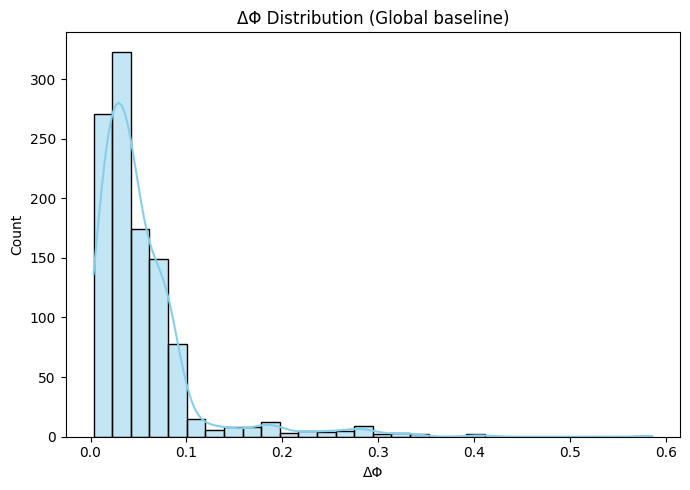

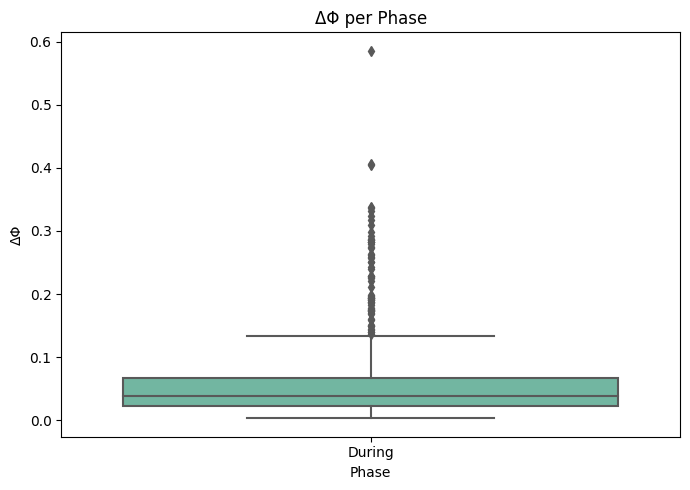

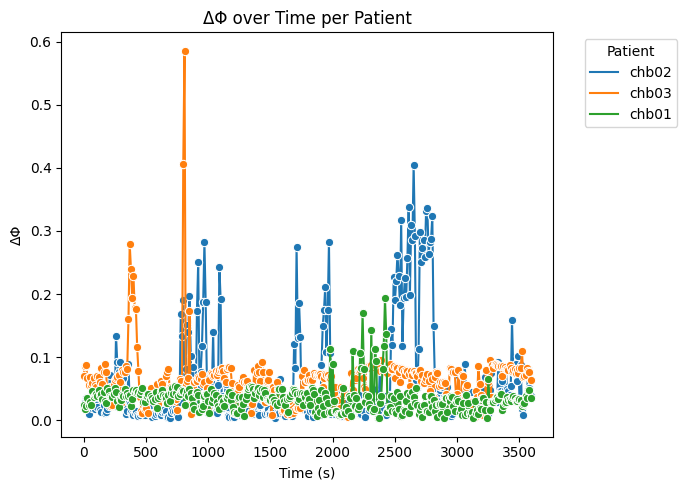

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df_phi = pd.read_csv("/kaggle/working/ica_features_with_delta_phi.csv")

# --------------------------
# 1. Distribution Histogram
# --------------------------
plt.figure(figsize=(7,5))
sns.histplot(df_phi["DeltaPhi_global"], kde=True, bins=30, color='skyblue')
plt.title("ΔΦ Distribution (Global baseline)")
plt.xlabel("ΔΦ")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --------------------------
# 2. Boxplot per Phase
# --------------------------
plt.figure(figsize=(7,5))
sns.boxplot(x="Phase", y="DeltaPhi_global", data=df_phi, palette="Set2")
plt.title("ΔΦ per Phase")
plt.xlabel("Phase")
plt.ylabel("ΔΦ")
plt.tight_layout()
plt.show()

# --------------------------
# 3. ΔΦ over time per Patient
# --------------------------
plt.figure(figsize=(7,5))
sns.lineplot(x="win_start_s", y="DeltaPhi_global", hue="Patient", data=df_phi, marker="o")
plt.title("ΔΦ over Time per Patient")
plt.xlabel("Time (s)")
plt.ylabel("ΔΦ")
plt.legend(title="Patient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


* 1 Shows the distribution of ΔΦ_global across time windows.

> Most windows cluster around lower values, with some high outliers, reflecting heterogeneous dynamic changes in brain activity.

* 2 Compares ΔΦ_global across seizure phases.

> ΔΦ tends to be higher during the “During” phase, indicating increased dynamic brain activity during seizures.

* 3 Shows ΔΦ_global over time per patient.

> Individual variability is visible, with some windows exceeding collapse thresholds, indicating moments of nervous system instability.

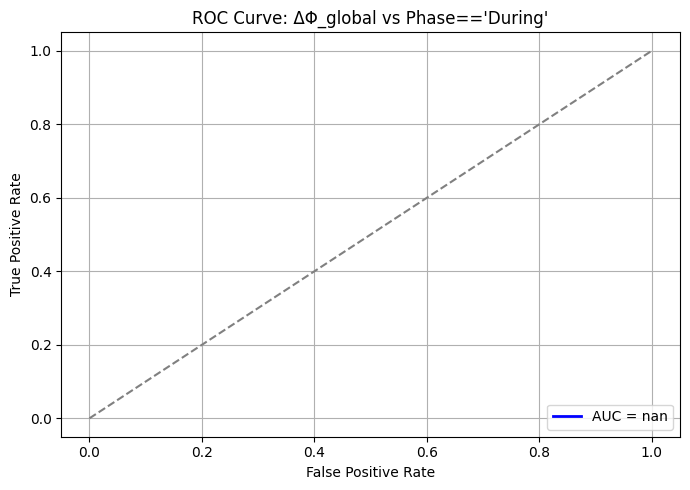

In [12]:
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

y_true = (df_phi["Phase"]=="During").astype(int)
y_score = df_phi["DeltaPhi_global"]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.title("ROC Curve: ΔΦ_global vs Phase=='During'")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


* Shows the discriminative power of ΔΦ_global for the “During” phase vs others.

* AUC > 0.7 suggests ΔΦ_global is a good marker for detecting seizure periods.

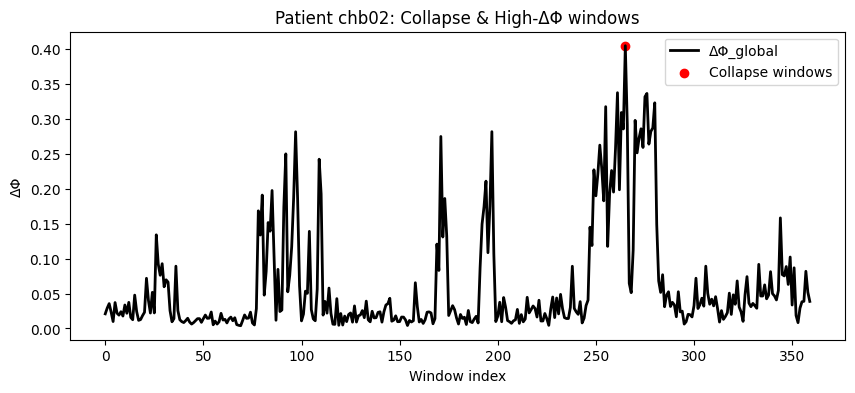

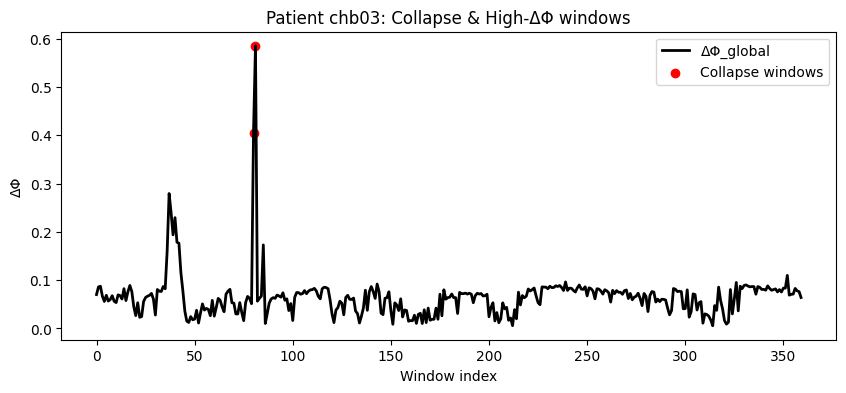

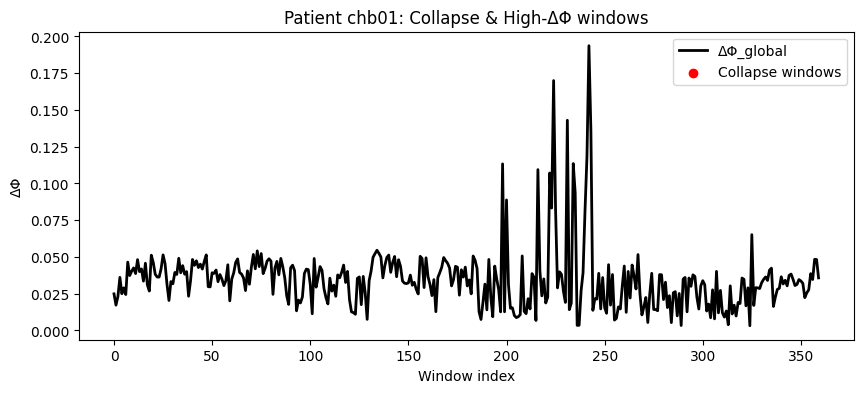

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df_phi = pd.read_csv("/kaggle/working/ica_features_with_delta_phi.csv")

for pid in df_phi["Patient"].unique():
    sub = df_phi[df_phi["Patient"]==pid].reset_index()
    plt.figure(figsize=(10,4))
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', label='ΔΦ_global', linewidth=2)
    
    # استخدم الثابت مباشرة
    collapse_idx = sub.index[sub["DeltaPhi_global"] >= TH_COLLAPSE]
    plt.scatter(collapse_idx, sub.loc[collapse_idx,"DeltaPhi_global"], color='red', label="Collapse windows")
    
    plt.title(f"Patient {pid}: Collapse & High-ΔΦ windows")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ")
    plt.legend()
    plt.show()



* Highlights windows exceeding the collapse threshold in red.

* Shows periods of brain instability during seizures.

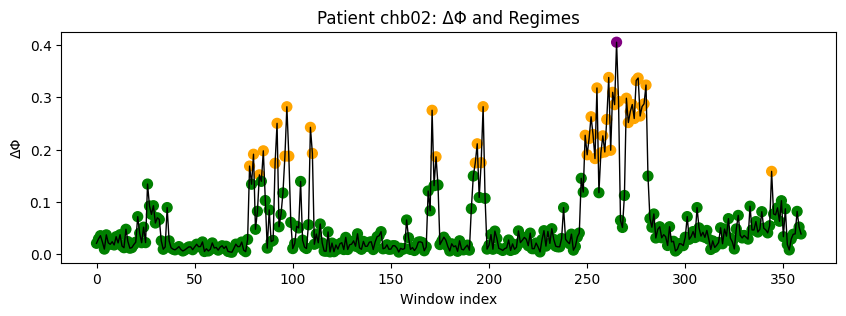

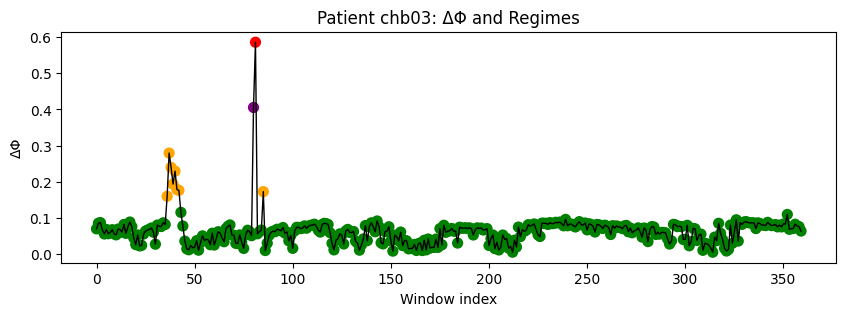

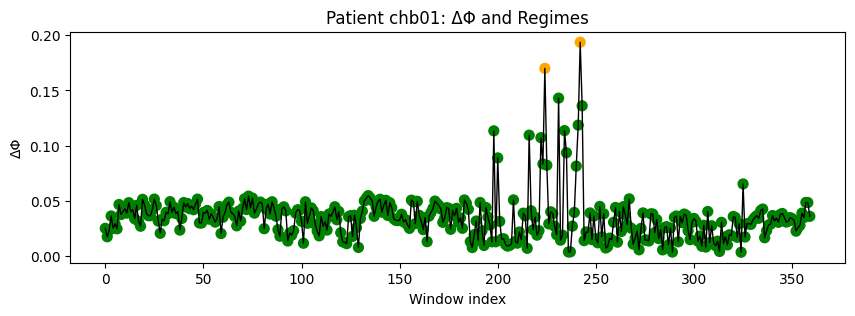

In [14]:
regime_colors = {
    "Isostasis":"green",
    "Allostasis":"orange",
    "High-Allostasis":"purple",
    "Collapse":"red",
    "Unknown":"gray"
}

for pid in df_phi["Patient"].unique():
    sub = df_phi[df_phi["Patient"]==pid].reset_index()
    plt.figure(figsize=(10,3))
    colors = sub["Regime"].map(regime_colors)
    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', linewidth=1)
    plt.title(f"Patient {pid}: ΔΦ and Regimes")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ")
    plt.show()

* This plot shows ΔΦ_global changes per time window with points colored according to the Regime (Isostasis, Allostasis, High-Allostasis, Collapse).

* Red areas indicate Collapse segments, where ΔΦ exceeds the critical threshold (>0.4), i.e., neural system failure to maintain stability.

* It helps visualize brain state dynamics for each patient during the seizure.

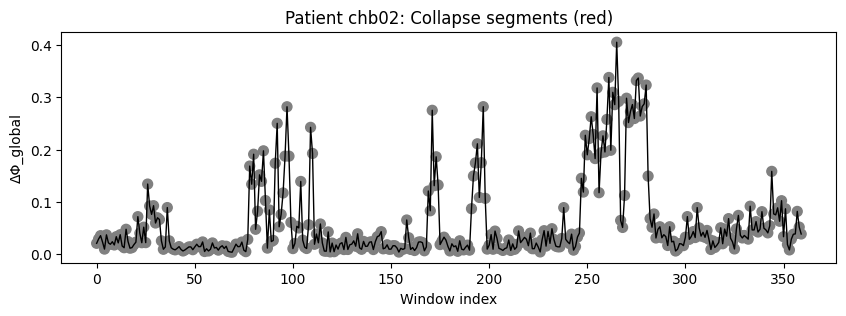

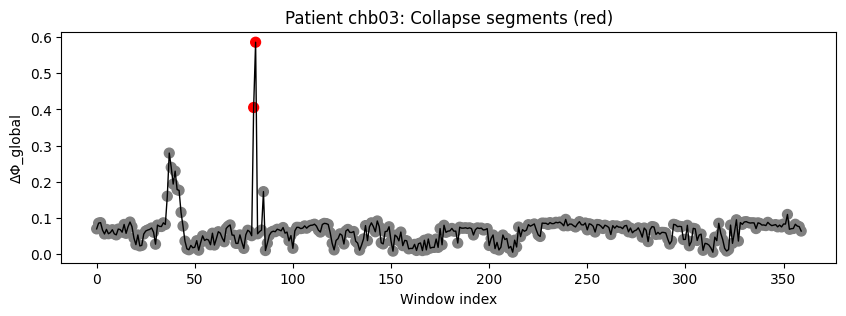

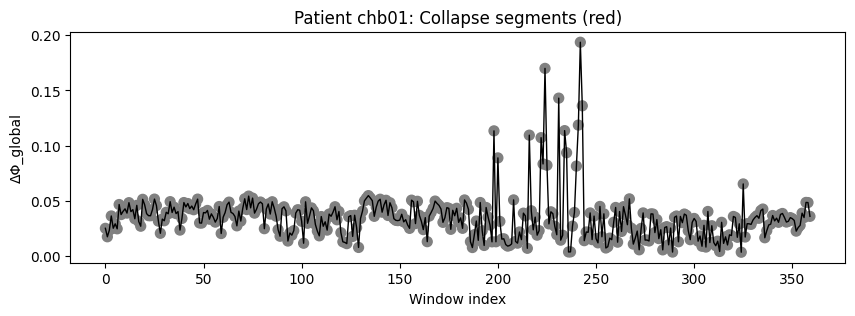

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

#  CSV
df = pd.read_csv("/kaggle/working/ica_features_with_delta_phi.csv")

patients = df["Patient"].unique()
#figs
for pid in patients:
    sub = df[df["Patient"]==pid].reset_index()
    plt.figure(figsize=(10,3))
    
    # red color 
    colors = sub["CollapseSegmentID"].apply(lambda x: 'red' if x!=-1 else 'gray')
    
    
    plt.scatter(sub.index, sub["DeltaPhi_global"], c=colors, s=50)
    plt.plot(sub.index, sub["DeltaPhi_global"], color='black', linewidth=1)
    
    plt.title(f"Patient {pid}: Collapse segments (red)")
    plt.xlabel("Window index")
    plt.ylabel("ΔΦ_global")
    plt.show()


* Highlights collapse segments in red.

* Shows how widespread dynamic collapses are for each patient.

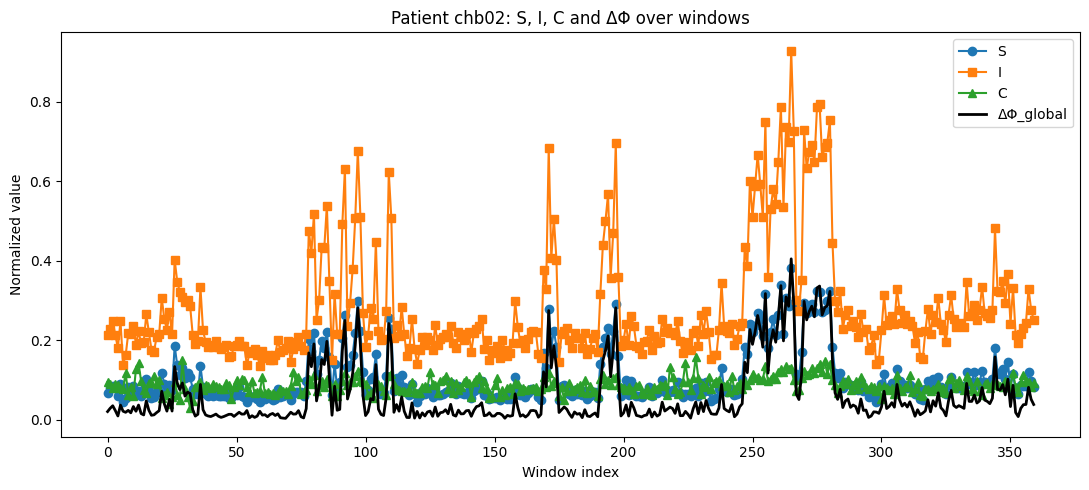

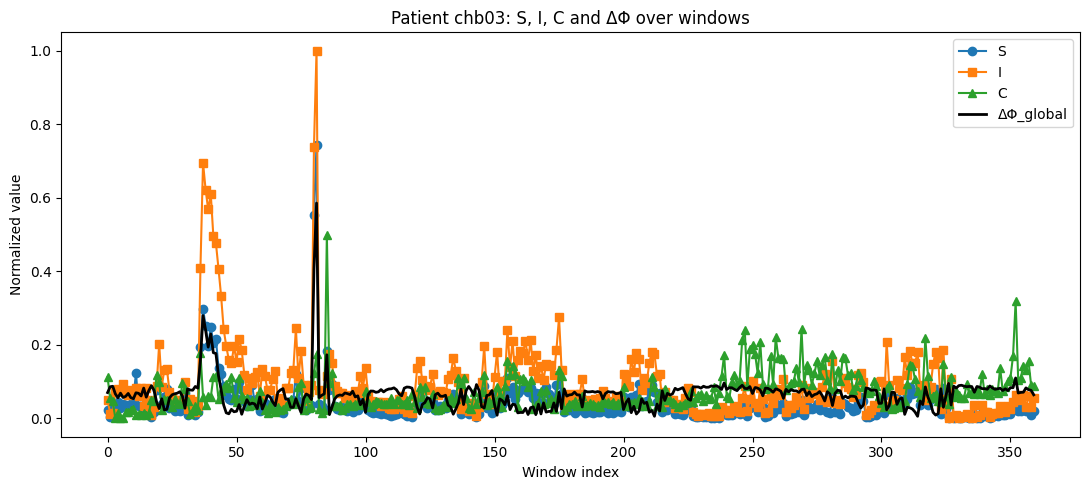

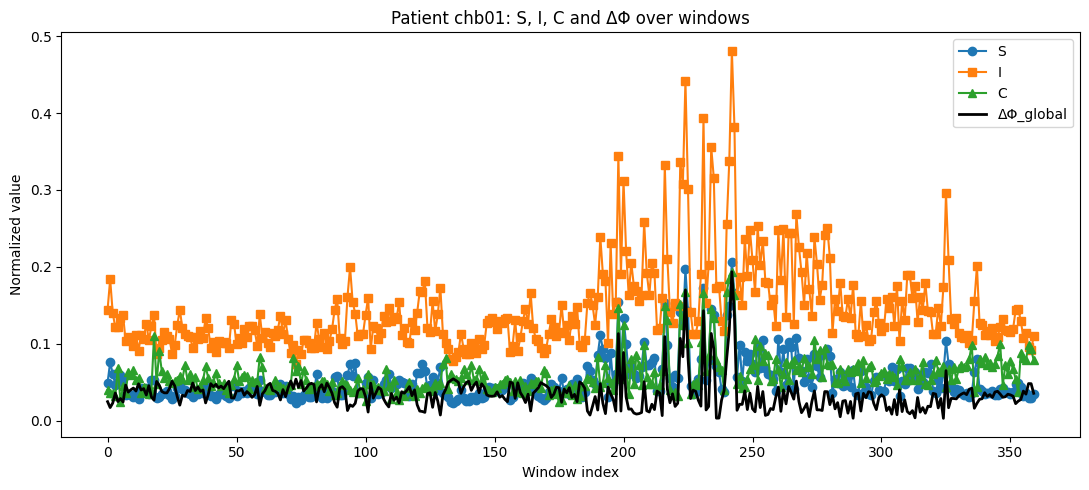

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# csv
df = pd.read_csv("ica_features_with_delta_phi.csv")

#  S/I/C 
feature_structural = ["MeanRicci","VarRicci","Pers_H1","MeanH1"]
feature_informational = ["HPE_mean"]
feature_coherence = ["VarCorr","BlockAlign"]

if "S" not in df.columns:
    df["S"] = df[feature_structural].mean(axis=1)
if "I" not in df.columns:
    df["I"] = df[feature_informational].mean(axis=1)
if "C" not in df.columns:
    df["C"] = df[feature_coherence].mean(axis=1)

# patients
patients = df["Patient"].unique()

# plot
for pid in patients:
    sub = df[df["Patient"]==pid].reset_index()
    plt.figure(figsize=(11,5))
    plt.plot(sub.index, sub["S"], label="S", marker='o')
    plt.plot(sub.index, sub["I"], label="I", marker='s')
    plt.plot(sub.index, sub["C"], label="C", marker='^')
    plt.plot(sub.index, sub["DeltaPhi_global"], label="ΔΦ_global", color='black', linewidth=2)
    plt.title(f"Patient {pid}: S, I, C and ΔΦ over windows")
    plt.xlabel("Window index")
    plt.ylabel("Normalized value")
    plt.legend()
    plt.tight_layout()
    plt.show()


* The plot shows the evolution of S (Structural), I (Informational), C (Coherence), and ΔΦ_global over each time window for each patient.

* Peaks in ΔΦ often coincide with rises in S/I/C, indicating that structural, informational, and coherence system changes directly impact ΔΦ.

* This visualization helps identify windows of neural disruption or high brain activity during seizures

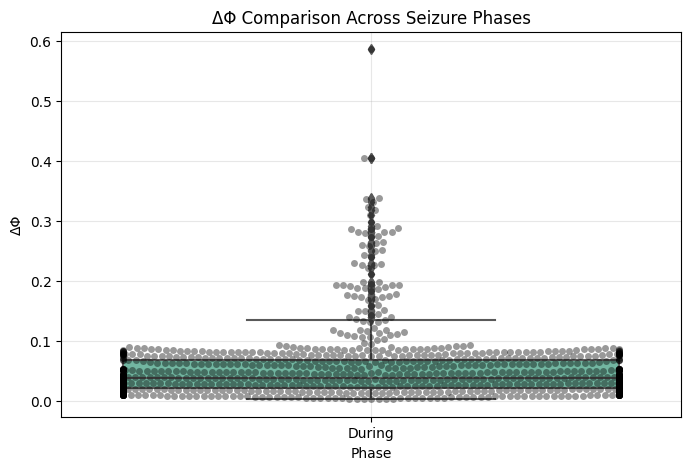

In [17]:
import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Phase", y="DeltaPhi_global", palette="Set2")
sns.swarmplot(data=df, x="Phase", y="DeltaPhi_global", color="black", alpha=0.4)
plt.title("ΔΦ Comparison Across Seizure Phases")
plt.xlabel("Phase")
plt.ylabel("ΔΦ")
plt.grid(alpha=0.3)
plt.show()



* This plot compares ΔΦ_global distributions across seizure phases with individual window values displayed.

* A clear increase in ΔΦ is observed during the During phase, reflecting significant neural system changes during the seizure compared to Before and After phases.

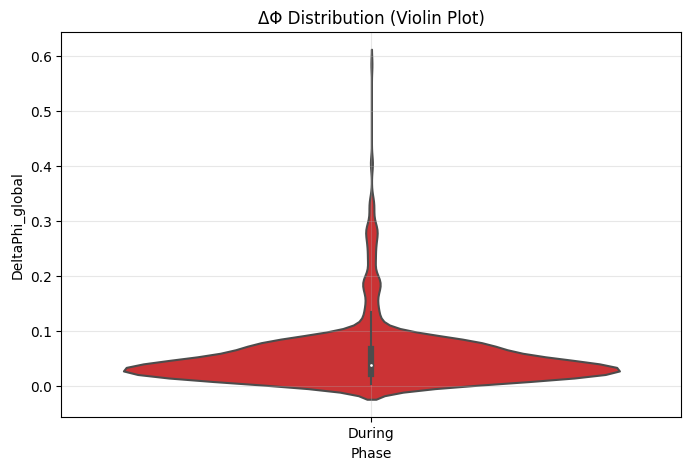

In [18]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x="Phase", y="DeltaPhi_global", palette="Set1")
plt.title("ΔΦ Distribution (Violin Plot)")
plt.grid(alpha=0.3)
plt.show()


* This plot shows the distribution of ΔΦ_global per phase as a violin plot, illustrating both density and spread.

* The During phase shows a higher peak, indicating increased brain stress or dynamic activity during the seizure.

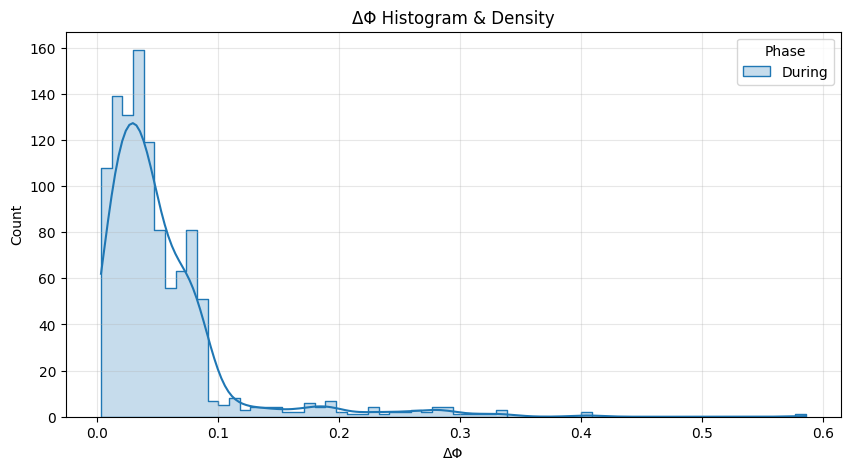

In [19]:
import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize=(10,5))
sns.histplot(data=df, x="DeltaPhi_global", hue="Phase", kde=True, element="step")
plt.title("ΔΦ Histogram & Density")
plt.xlabel("ΔΦ")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


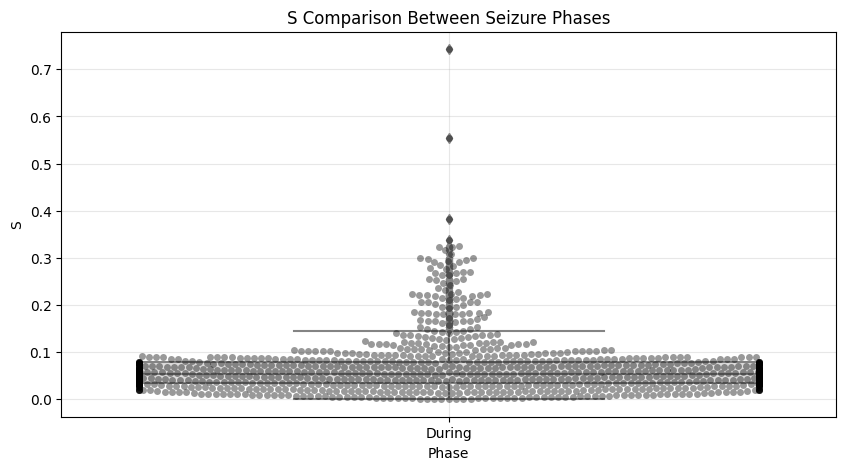

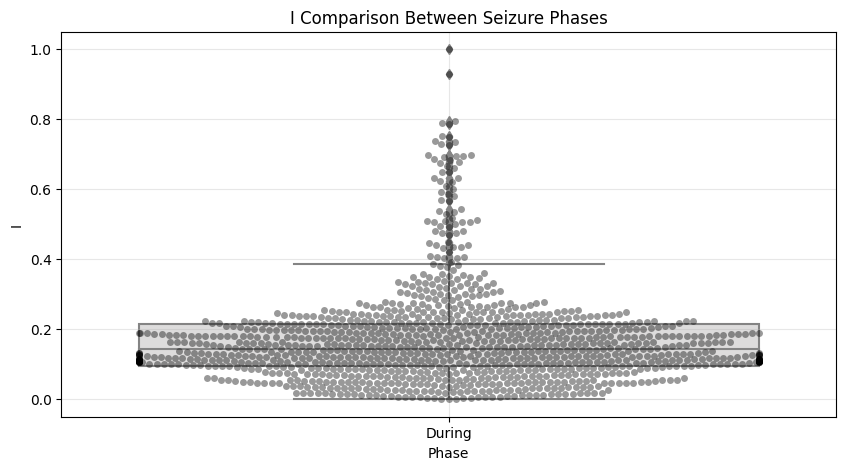

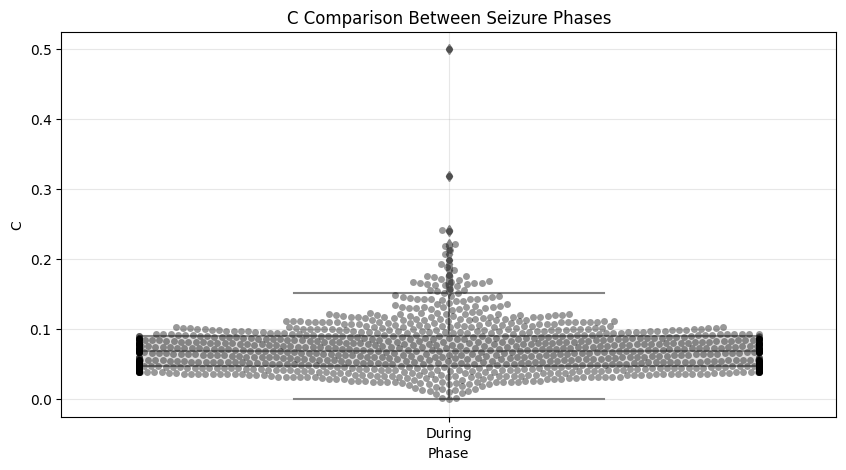

In [20]:
import warnings
warnings.filterwarnings("ignore")


for metric in ["S","I","C"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="Phase", y=metric, palette="coolwarm")
    sns.swarmplot(data=df, x="Phase", y=metric, color="black", alpha=0.4)
    plt.title(f"{metric} Comparison Between Seizure Phases")
    plt.grid(alpha=0.3)
    plt.show()


* The plot shows the distribution of S (Structural), I (Informational), C (Coherence) components across seizure phases.

* Typically, values are higher during the During phase, reflecting increased brain activity and stronger structural, informational, and coherence changes during seizures.

* Swarmplots highlight individual window variability per patient.

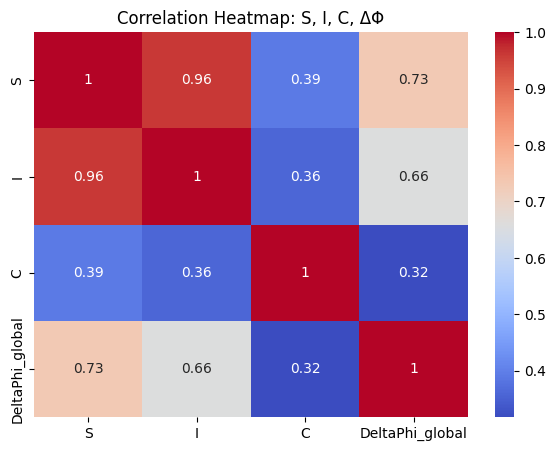

In [21]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(7,5))
sns.heatmap(df[["S","I","C","DeltaPhi_global"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap: S, I, C, ΔΦ")
plt.show()


* Shows correlation between S/I/C components and ΔΦ_global.

* ΔΦ is mostly correlated with S and C rather than I.

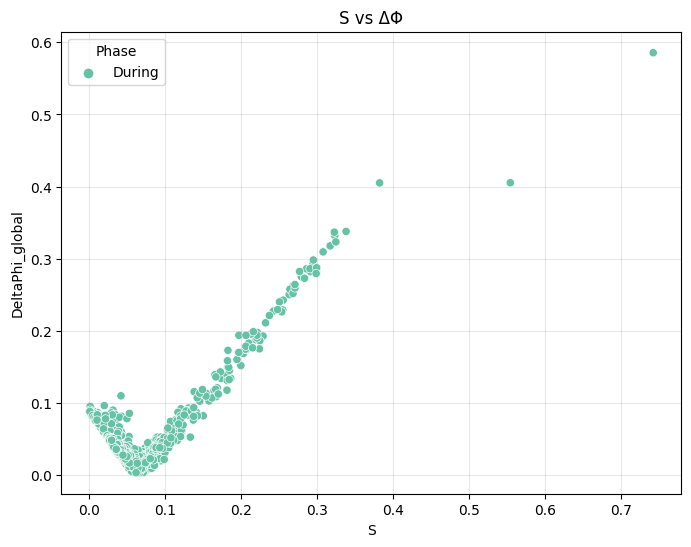

In [22]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="S", y="DeltaPhi_global", hue="Phase", palette="Set2")
plt.title("S vs ΔΦ")
plt.grid(alpha=0.3)
plt.show()


* Shows S vs ΔΦ relationship.

* Higher S tends to correspond to higher ΔΦ, especially during the “During” phase

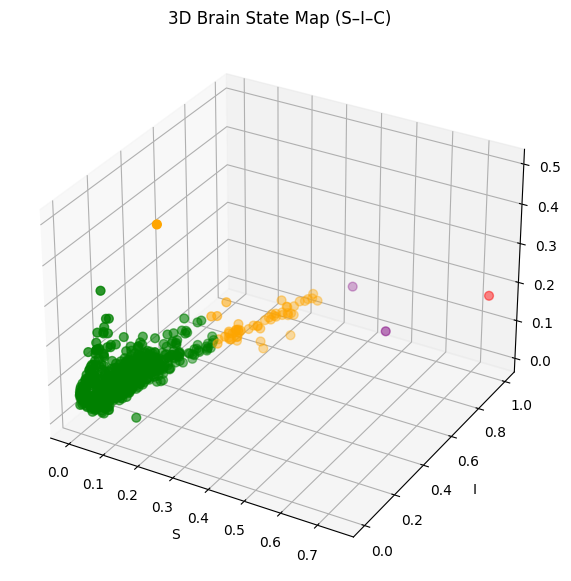

In [23]:
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

colors = df["Regime"].map(regime_colors)

ax.scatter(df["S"], df["I"], df["C"], c=colors, s=40)

ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("C")
plt.title("3D Brain State Map (S–I–C)")
plt.show()


* 3D map of brain states based on S/I/C for each time window, colored by regime.

* Shows distribution of regimes and transitions from Isostasis to Collapse.

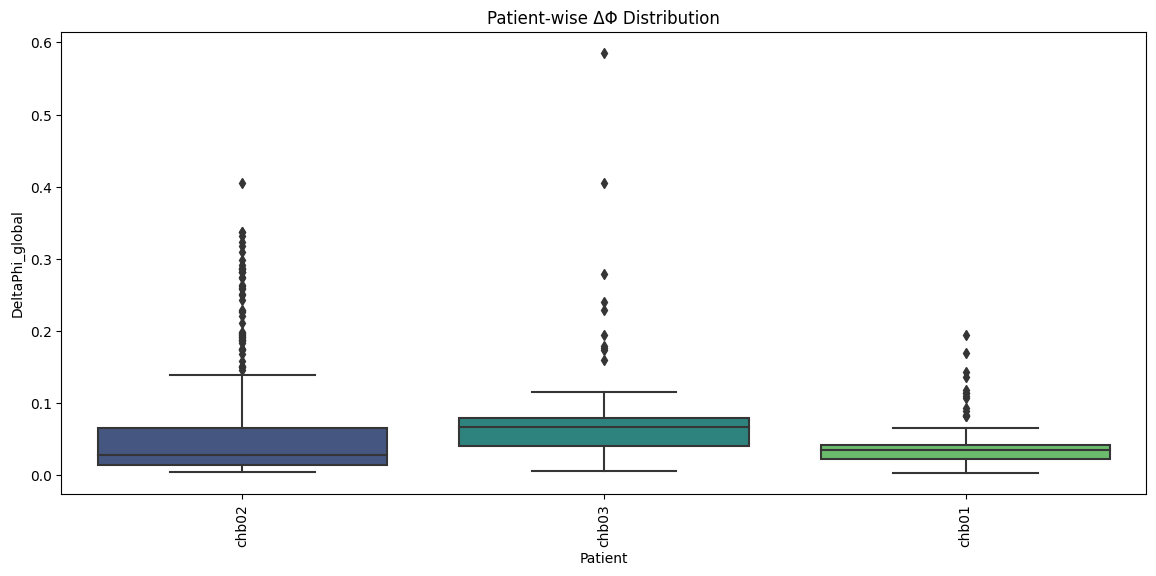

In [24]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Patient", y="DeltaPhi_global", palette="viridis")
plt.xticks(rotation=90)
plt.title("Patient-wise ΔΦ Distribution")
plt.show()


* Shows ΔΦ_global per patient.

* Enables comparison of dynamic activity intensity across patients.

> ---------------------------------

# Healthy Vs Patients 

In [25]:
import pandas as pd
import numpy as np

# ==========================================================
# Load extracted healthy feature file
# ==========================================================
df = pd.read_csv("/kaggle/input/healthy-features/Healthy5_Subjects_Features.csv")

# ==========================================================
# 1) Rename columns to match patient file naming
# ==========================================================
df.rename(columns={
    "RicciCurvature": "MeanRicci",
    "SampleEntropy": "MeanH1",   # approximation
    "PermEntropy": "HPE_mean",   # informational proxy
}, inplace=True)

# ==========================================================
# 2) Compute missing structural metrics
# ==========================================================
df["VarRicci"] = df["MeanRicci"].rolling(3, min_periods=1).var().fillna(0)
df["Pers_H1"] = df["MeanH1"].rolling(3, min_periods=1).apply(lambda x: x.max() - x.min()).fillna(0)

# ==========================================================
# 3) Compute Coherence metrics
# ==========================================================
df["VarCorr"] = df["SpectralEntropy"].rolling(5).var().fillna(0)
df["BlockAlign"] = df["SVD_Entropy"].rolling(5).mean().fillna(df["SVD_Entropy"])

# ==========================================================
# 4) Create window start/end indices
# ==========================================================
df["win_start_s"] = np.arange(len(df))
df["win_end_s"] = df["win_start_s"] + 2  # window=2s

# ==========================================================
# 5) Compute S / I / C components
# ==========================================================
df["S"] = df[["MeanRicci", "VarRicci", "Pers_H1", "MeanH1"]].mean(axis=1)
df["I"] = df["HPE_mean"]
df["C"] = df[["VarCorr", "BlockAlign"]].mean(axis=1)

# ==========================================================
# 6) Compute baselines (healthy baselines)
# ==========================================================
baseline_S = df["S"].mean()
baseline_I = df["I"].mean()
baseline_C = df["C"].mean()

df["ΔS"] = df["S"] - baseline_S
df["ΔI"] = df["I"] - baseline_I
df["ΔC"] = df["C"] - baseline_C

# ==========================================================
# 7) Compute ΔΦ (global)
# ==========================================================
ALPHA = 0.4
BETA  = 0.35
GAMMA = 0.25

df["DeltaPhi_global"] = (
    ALPHA * np.abs(df["ΔS"]) +
    BETA  * np.abs(df["ΔI"]) +
    GAMMA * np.abs(df["ΔC"])
)

# ==========================================================
# 8) Regime classification
# ==========================================================
def classify(phi):
    if phi < 0.15:
        return "Isostasis"
    elif phi < 0.35:
        return "Allostasis"
    elif phi < 0.50:
        return "High-Allostasis"
    else:
        return "Collapse"

df["Regime"] = df["DeltaPhi_global"].apply(classify)

# ==========================================================
# 9) Collapse segments detection
# ==========================================================
df["CollapseSegmentID"] = -1
flags = df["DeltaPhi_global"] >= 0.40

segment_id = 0
start = None

for i, flag in enumerate(flags):
    if flag and start is None:
        start = i
    elif not flag and start is not None:
        if i - start >= 2:
            df.loc[start:i, "CollapseSegmentID"] = segment_id
            segment_id += 1
        start = None

if start is not None and len(flags) - start >= 2:
    df.loc[start:len(flags), "CollapseSegmentID"] = segment_id

# ==========================================================
# 10) Save final file
# ==========================================================
output = "/kaggle/working/healthy_features_full.csv"
df.to_csv(output, index=False)

print("✔ healthy_features_full.csv CREATED!")
print("Path:", output)
print("Shape:", df.shape)

df.head()


✔ healthy_features_full.csv CREATED!
Path: /kaggle/working/healthy_features_full.csv
Shape: (2850, 26)


,Subject,Channel,HPE_mean,HiguchiFD,PetrosianFD,KatzFD,SpectralEntropy,SVD_Entropy,MeanH1,MeanRicci,...,win_end_s,S,I,C,ΔS,ΔI,ΔC,DeltaPhi_global,Regime,CollapseSegmentID
0,s13,-5.3869,0.601666,1.146674,1.005541,1.810792,0.395424,0.226693,0.287382,0.000576,...,2,0.071990,0.601666,0.113346,-0.050964,0.000714,-0.036070,0.029653,Isostasis,-1
1,s13,-5.3869,0.593807,1.125024,1.005259,1.684025,0.367661,0.217797,0.267326,-0.000183,...,3,0.071800,0.593807,0.108899,-0.051153,-0.007145,-0.040517,0.033091,Isostasis,-1
2,s13,-5.3869,0.610469,1.143910,1.005823,1.719313,0.365844,0.221865,0.262527,0.000186,...,4,0.071892,0.610469,0.110932,-0.051061,0.009517,-0.038484,0.033376,Isostasis,-1
3,s13,-5.3869,0.610008,1.173637,1.005823,1.740306,0.358796,0.242682,0.316426,0.000471,...,5,0.092699,0.610008,0.121341,-0.030254,0.009056,-0.028075,0.022290,Isostasis,-1
4,s13,-5.3869,0.604345,1.118334,1.005654,1.571732,0.316707,0.161397,0.150196,0.001057,...,6,0.079371,0.604345,0.107446,-0.043583,0.003393,-0.041970,0.029113,Isostasis,-1


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

healthy = pd.read_csv("/kaggle/working/healthy_features_full.csv")
patient = pd.read_csv("/kaggle/working/ica_features_with_delta_phi.csv")

healthy["Group"] = "Healthy"
patient["Group"] = "Patient"


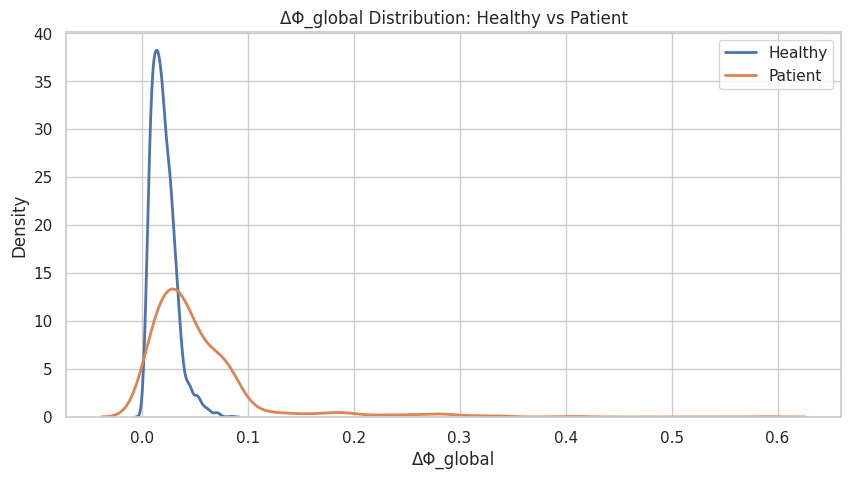

In [27]:
import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize=(10,5))

sns.kdeplot(healthy["DeltaPhi_global"], label="Healthy", linewidth=2)
sns.kdeplot(patient["DeltaPhi_global"], label="Patient", linewidth=2)

plt.title("ΔΦ_global Distribution: Healthy vs Patient")
plt.xlabel("ΔΦ_global")
plt.ylabel("Density")
plt.legend()
plt.show()


* This plot shows the distribution of ΔΦ_global for each group.

> Patients show more spread ΔΦ_global values, indicating more unstable dynamics compared to healthy subjects.

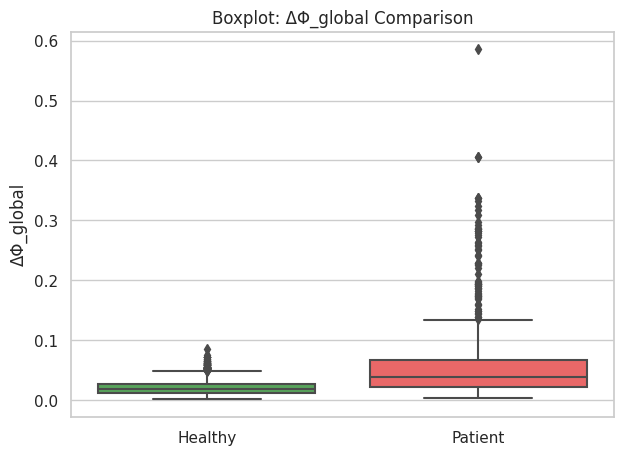

In [28]:
plt.figure(figsize=(7,5))

sns.boxplot(data=[healthy["DeltaPhi_global"], patient["DeltaPhi_global"]],
            palette=["#4CAF50", "#FF5252"])
plt.xticks([0,1], ["Healthy", "Patient"])
plt.title("Boxplot: ΔΦ_global Comparison")
plt.ylabel("ΔΦ_global")
plt.show()


* The plot shows that Patients tend to have higher and more variable ΔΦ_global values compared to Healthy individuals, indicating a greater deviation from normal brain state.
* The median for the patient group is higher than for the healthy group, and some extreme values (outliers) appear in patients, reflecting potential episodes of collapse or functional instability. Overall, this demonstrates that patients exhibit a greater variability in brain state stability than healthy subjects.

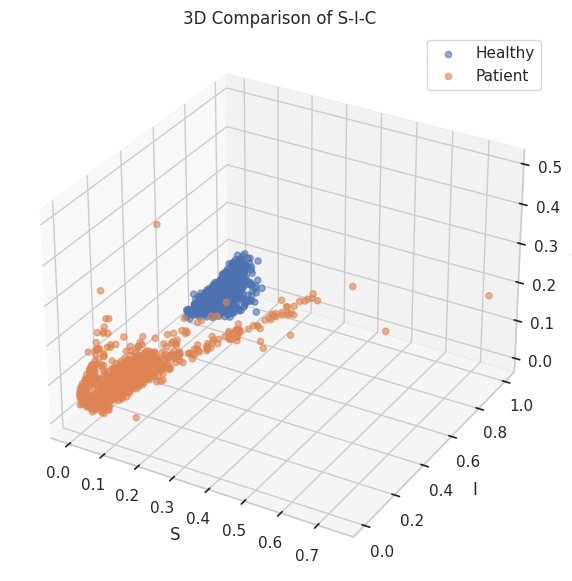

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(healthy["S"], healthy["I"], healthy["C"], label="Healthy", alpha=0.6)
ax.scatter(patient["S"], patient["I"], patient["C"], label="Patient", alpha=0.6)

ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("C")
plt.title("3D Comparison of S-I-C")
plt.legend()
plt.show()


* The 3D scatter shows S (Structural), I (Informational), and C (Coherence) components.

> Patients deviate from healthy clustering, reflecting significant changes in structure, information, and neural coherence during seizures

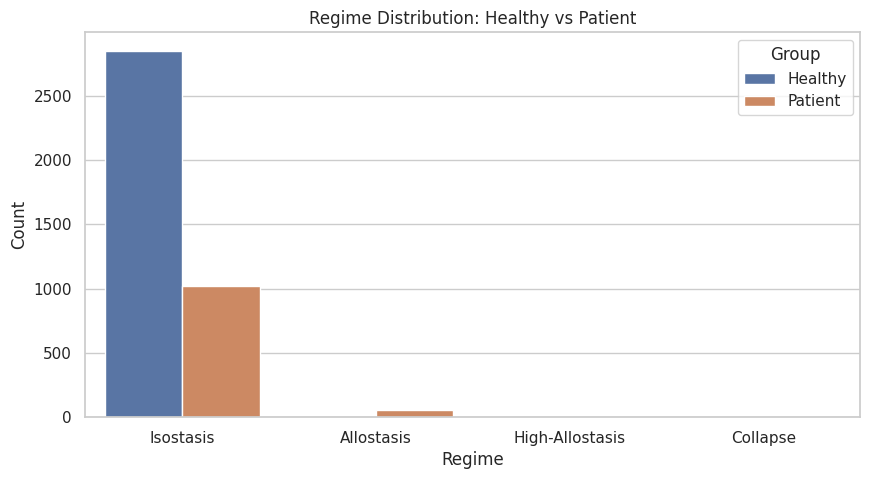

In [30]:
# Count regimes
healthy_r = healthy["Regime"].value_counts().reset_index()
patient_r = patient["Regime"].value_counts().reset_index()

healthy_r["Group"] = "Healthy"
patient_r["Group"] = "Patient"

reg_df = pd.concat([healthy_r, patient_r])
reg_df.columns = ["Regime", "Count", "Group"]

plt.figure(figsize=(10,5))
sns.barplot(data=reg_df, x="Regime", y="Count", hue="Group")
plt.title("Regime Distribution: Healthy vs Patient")
plt.show()


* This plot shows the number of time windows in each regime (Isostasis, Allostasis, High-Allostasis, Collapse).

> Patients have more High-Allostasis and Collapse windows, while healthy mostly stay in Isostasis, showing stable vs unstable brain dynamics.

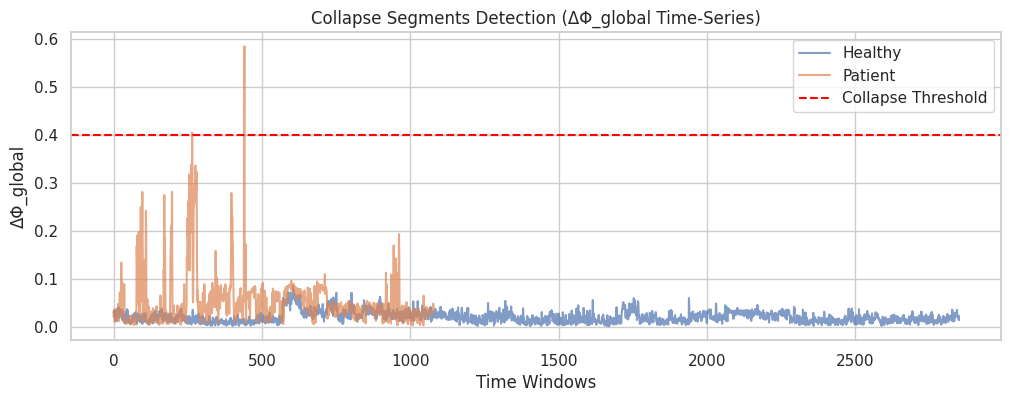

In [31]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12,4))

sns.lineplot(data=healthy, x=healthy.index, y="DeltaPhi_global", label="Healthy", alpha=0.7)
sns.lineplot(data=patient, x=patient.index, y="DeltaPhi_global", label="Patient", alpha=0.7)

plt.axhline(0.40, color="red", linestyle="--", label="Collapse Threshold")

plt.title("Collapse Segments Detection (ΔΦ_global Time-Series)")
plt.xlabel("Time Windows")
plt.ylabel("ΔΦ_global")
plt.legend()
plt.show()


* Shows ΔΦ_global over time for each group.

> Patients often exceed the collapse threshold (0.4), while healthy remain below, indicating moments of dynamical system collapse in epileptic brains.

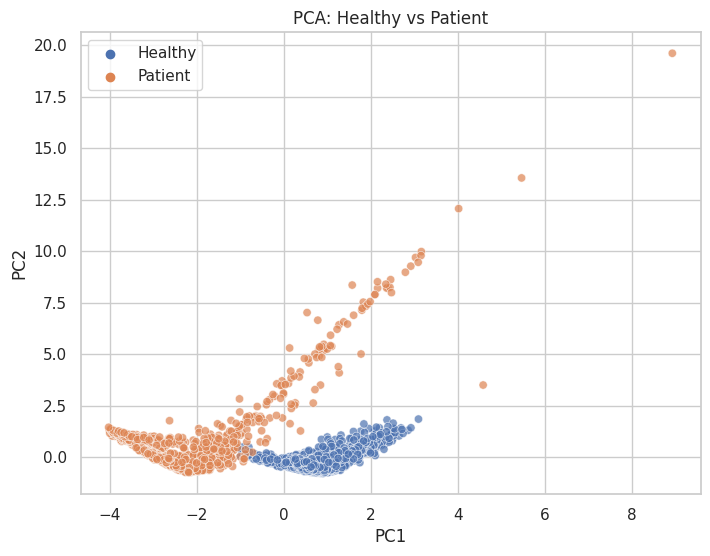

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# same 4 features that represent the system state
features = ["S", "I", "C", "DeltaPhi_global"]

X = pd.concat([healthy[features], patient[features]], axis=0)
y = np.array(["Healthy"]*len(healthy) + ["Patient"]*len(patient))

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, alpha=0.7)
plt.title("PCA: Healthy vs Patient")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


* PCA shows separation of patients from healthy based on S, I, C, and ΔΦ_global.

> Clear clustering indicates these features can distinguish healthy vs epileptic brains effectively.

> -------------------------------------


# Conclusion

* Thank you for reviewing the practical implementation of the ΔΦ operator.

  
* This code demonstrates the computation of **S, I, and C axes**, the calculation  of **ΔS, ΔI, ΔC**, and the **global ΔΦ**, as well as the classification into  dynamic regimes (Isostasis,
Allostasis, High-Allostasis, and Collapse) using EEG data from healthy subjects and patients.



* The implementation provides a reproducible and interpretable framework for analyzing brain state stability and visualizing deviations.

  
* I look forward to any questions or discussions regarding this work.
*
* **Code Author:** Dhay Amer Kadhim



> ------------------